In [1]:
# 必要なライブラリを読込
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import chainer
import chainer.functions as F           # パラメータを含まない関数を収録したパッケージ
import chainer.links as L               # パラメータを含む関数を収録したパッケージ
from chainer import computational_graph # グラフを出力するパッケージ
from chainer import serializers         # モデルの保存や読込を行うパッケージ
from chainer import optimizers

C:\Users\yuubo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X=np.load("X_train.npy").reshape(-1,1,50,37)
y=np.load("y_train.npy")
y=y.astype(np.int32)

In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [4]:
print(len(X_train))
print(len(X_test))
print(X_train.shape)

676
290
(676, 1, 50, 37)


In [5]:
def draw_picture(data):
    img=data.reshape(50,37)
    
    plt.imshow(img)
    
    plt.show()

In [6]:
X_train/=255.0
X_test/=255.0

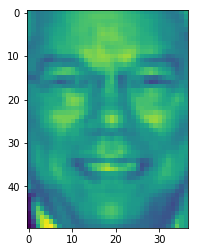

In [7]:
draw_picture(X_train[0])

In [8]:
# CNNの定義
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 7) # out_channelはクラス数と同じ5に設定
        
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)


In [9]:
model=L.Classifier(CNN())

In [10]:
optimizer=chainer.optimizers.SGD()
optimizer.setup(model)

In [11]:
batch_size=100
n_epoch=100

In [12]:
from chainer.datasets import tuple_dataset
from chainer import iterators,training
from chainer.training import extensions

In [13]:
train=tuple_dataset.TupleDataset(X_train,y_train)

In [14]:
train_iter=iterators.SerialIterator(train,batch_size=batch_size,shuffle=True)

In [15]:
updater=training.StandardUpdater(train_iter,optimizer)

In [16]:
trainer=training.Trainer(updater,(n_epoch,"epoch"),out="result")

In [17]:
test=tuple_dataset.TupleDataset(X_test,y_test)
test_iter=iterators.SerialIterator(test,batch_size=batch_size,shuffle=False,repeat=False)
trainer.extend(extensions.Evaluator(test_iter,model))

In [18]:
trainer.extend(extensions.LogReport())

In [19]:
trainer.extend(extensions.PrintReport(["epoch","main/accuracy","main/loss","validation/main/accuracy","validation/main/loss"]))

In [20]:
trainer.extend(extensions.ProgressBar())

In [21]:
trainer.extend(extensions.PlotReport(["main/accuracy","validation/main/accuracy"],"epoch",file_name="accuracy_Labeled_Faces_in_the_Wild.png"))

trainer.extend(extensions.PlotReport(["main/loss","validation/main/loss"],"epoch",file_name="loss_Labeled_Faces_in_the_Wild.png"))

In [22]:
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.402857       1.73854     0.408148                  1.69165               
2           0.41           1.67341     0.408148                  1.68289               
3           0.418571       1.64262     0.408148                  1.69158               
4           0.414286       1.66318     0.408148                  1.68333               
5           0.393333       1.66837     0.408148                  1.67625               
6           0.411429       1.64511     0.408148                  1.67292               
7           0.42           1.64327     0.408148                  1.65916               
8           0.41           1.63498     0.408148                  1.66138               
9           0.418333       1.62005     0.408148                  1.67645               
10          0.415714       1.62203     0.411481                  1.64954               
11          0.428571       1.63975

80          0.693333       0.933782    0.611481                  1.1559                
81          0.694286       0.944628    0.594444                  1.2378                
82          0.638571       1.08073     0.626667                  1.07063               
83          0.678571       0.8865      0.587407                  1.2148                
84          0.641667       1.02604     0.665185                  1.0601                
85          0.747143       0.844934    0.601481                  1.13244               
86          0.685714       0.96548     0.61963                   1.11414               
87          0.685714       0.897222    0.443704                  1.56142               
88          0.655          1.05264     0.694815                  1.01178               
     total [############################################......] 88.76%
this epoch [#####################################.............] 75.74%
       600 iter, 88 epoch / 100 epochs
  0.068087 iters/sec. Estim

In [ ]:
serializers.save_npz("LFW.model",)